In [1]:
## -- Device-Agnostic for GPU --
import torch
print(f"ℹ️ Cuda available: {torch.cuda.is_available()}")

# import cuml.accel
# cuml.accel.install()

%load_ext cudf.pandas
from cuml.preprocessing import TargetEncoder as cuTE

ℹ️ Cuda available: True


In [2]:
## -- IMPORT LIBRARIES --
import sys, os, gc

## -- DATA MANIPUALATION --
import numpy as np, pandas as pd, random

## -- VISUALISATION --
from IPython.display import display, Image
import matplotlib.pyplot as plt
import seaborn as sns
import shap

## -- FUNCTIONAL TOOLS --
from time import time, sleep
from tqdm.notebook import tqdm
from itertools import combinations, product

## -- MACHINE LEARNING --
import lightgbm as lgb

import sklearn
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.metrics import (
                roc_auc_score,
                RocCurveDisplay,
                ConfusionMatrixDisplay,
                classification_report
)

import warnings

In [3]:
print(f"sklearn version: {sklearn.__version__}")
print(f"lgboost version: {lgb.__version__}")

sklearn version: 1.2.2
lgboost version: 4.6.0


In [4]:
## -- Global Settings --
# sklearn.set_config(transform_output="pandas")
warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')

# pd.options.mode.copy_on_write = True
pd.set_option('display.max_columns', 1000)
# plt.style.use("ggplot")
sns.set_style("darkgrid")
cmap = sns.diverging_palette(0, 230, 90, 60, as_cmap=True)

## -- Set Global Seed --
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

COLOR = '\033[32m'
RESET = '\033[0m'

# from google.colab import data_table
# data_table.enable_dataframe_formatter()

In [5]:
### Load Data ###
PATH = "/kaggle/input/playground-series-s5e11/"
submit = pd.read_csv(PATH+"sample_submission.csv")
train = pd.read_csv(PATH+"train.csv").drop(['id'], axis=1)
test = pd.read_csv(PATH+"test.csv").drop(['id'], axis=1)

TARGET = "loan_paid_back"
NUMS = test.select_dtypes(include='number').columns.tolist()
CATS = test.select_dtypes(exclude='number').columns.tolist()
BASE = NUMS + CATS

ORIG_PATH = "/kaggle/input/loan-prediction-dataset-2025/"
orig = pd.read_csv(ORIG_PATH+"loan_dataset_20000.csv")[BASE+[TARGET]]

for (name, df) in dict(Train=train, Test=test, Original=orig).items():
    print(f"{name} shape: {df.shape}")

print(f"\nTotal Numerical: {len(NUMS)}")
print(f"Total Categorical: {len(CATS)}")
print(f"Total base features: {len(BASE)}")

Train shape: (593994, 12)
Test shape: (254569, 11)
Original shape: (20000, 12)

Total Numerical: 5
Total Categorical: 6
Total base features: 11


In [6]:
# ### Load Data ###
# submit = pd.read_csv("sample_submission.csv")
# train = pd.read_csv("train.csv",index_col='id') #.drop('id', axis=1)
# test = pd.read_csv("test.csv", index_col='id') #.drop('id', axis=1)

# TARGET = "loan_paid_back"
# NUMS = test.select_dtypes(include='number').columns.tolist()
# CATS = test.select_dtypes(exclude='number').columns.tolist()
# BASE = NUMS + CATS

# orig = pd.read_csv("loan_dataset_20000.csv")[BASE+[TARGET]]

# for (name, df) in dict(Train=train, Test=test, Original=orig).items():
#     print(f"{name} shape: {df.shape}")

# print(f"\nTotal Numerical: {len(NUMS)}")
# print(f"Total Categorical: {len(CATS)}")
# print(f"Total base features: {len(BASE)}")

In [7]:
# display(test.head())
train.info()

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 593994 entries, 0 to 593993
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype
---  ------                --------------   -----
 0   annual_income         593994 non-null  float64
 1   debt_to_income_ratio  593994 non-null  float64
 2   credit_score          593994 non-null  int64
 3   loan_amount           593994 non-null  float64
 4   interest_rate         593994 non-null  float64
 5   gender                593994 non-null  object
 6   marital_status        593994 non-null  object
 7   education_level       593994 non-null  object
 8   employment_status     593994 non-null  object
 9   loan_purpose          593994 non-null  object
 10  grade_subgrade        593994 non-null  object
 11  loan_paid_back        593994 non-null  float64
dtypes: float64(5), int64(1), object(6)
memory usage: 65.8+ MB


In [8]:
train.head()

,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back
0,29367.99,0.084,736,2528.42,13.67,Female,Single,High School,Self-employed,Other,C3,1.0
1,22108.02,0.166,636,4593.10,12.92,Male,Married,Master's,Employed,Debt consolidation,D3,0.0
2,49566.20,0.097,694,17005.15,9.76,Male,Single,High School,Employed,Debt consolidation,C5,1.0
3,46858.25,0.065,533,4682.48,16.10,Female,Single,High School,Employed,Debt consolidation,F1,1.0
4,25496.70,0.053,665,12184.43,10.21,Male,Married,High School,Employed,Other,D1,1.0


In [9]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
annual_income,593994.0,48212.202976,26711.942078,6002.430,27934.400,46557.680,60981.320,393381.740
debt_to_income_ratio,593994.0,0.120696,0.068573,0.011,0.072,0.096,0.156,0.627
credit_score,593994.0,680.916009,55.424956,395.000,646.000,682.000,719.000,849.000
loan_amount,593994.0,15020.297629,6926.530568,500.090,10279.620,15000.220,18858.580,48959.950
interest_rate,593994.0,12.356345,2.008959,3.200,10.990,12.370,13.680,20.990
loan_paid_back,593994.0,0.798820,0.400883,0.000,1.000,1.000,1.000,1.000


In [10]:
test.describe().T

,count,mean,std,min,25%,50%,75%,max
annual_income,254569.0,48233.080193,26719.658580,6011.770,27950.300,46528.980,61149.440,380653.940
debt_to_income_ratio,254569.0,0.120583,0.068582,0.011,0.072,0.096,0.156,0.627
credit_score,254569.0,681.037691,55.624118,395.000,646.000,683.000,719.000,849.000
loan_amount,254569.0,15016.753484,6922.165182,500.050,10248.580,15000.220,18831.460,48959.260
interest_rate,254569.0,12.352323,2.017602,3.200,10.980,12.370,13.690,21.290


In [11]:
train.nunique(dropna=False).sort_values(ascending=False)

annual_income           119728
loan_amount             111570
interest_rate             1454
debt_to_income_ratio       526
credit_score               399
grade_subgrade              30
loan_purpose                 8
education_level              5
employment_status            5
marital_status               4
gender                       3
loan_paid_back               2
dtype: int64

# FEATURE ENGINEERING

In [12]:
# ## -- AutoGluon Probabilities --
# orig_margin = pd.read_csv("/kaggle/input/ps5e11-autogluon-original/origY_extreme.csv")
# orig_margin = orig_margin.rename(columns={'origY_extreme': 'y'})
# orig = pd.concat([orig, orig_margin], axis=1)

# train_margin = pd.read_csv("/kaggle/input/ps5e11-autogluon-original/trainY_extreme.csv")
# train_margin = train_margin.rename(columns={'trainY_extreme': 'y'})
# train = pd.concat([train, train_margin], axis=1)

# test_margin = pd.read_csv("/kaggle/input/ps5e11-autogluon-original/testY_extreme.csv")
# test_margin = test_margin.rename(columns={'testY_extreme': 'y'})
# test = pd.concat([test, test_margin], axis=1)

# ## -- Convert probas to logits --
# epsilon = 1e-6
# orig['y'] = logit(np.clip(orig['y'], epsilon, 1 - epsilon)) 
# train['y'] = logit(np.clip(train['y'], epsilon, 1 - epsilon)) 
# test['y'] = logit(np.clip(test['y'], epsilon, 1 - epsilon)) 

# train.head()

In [13]:
## -- Define categories for OHE --
CAT_COLS = [c for c in BASE if train[c].dtype=='object' or train[c].nunique() <= 0.01*len(train)]
print(f"ℹ️ Features for TE: {len(CAT_COLS)} -> {CAT_COLS}")

ℹ️ Features for TE: 9 -> ['debt_to_income_ratio', 'credit_score', 'interest_rate', 'gender', 'marital_status', 'education_level', 'employment_status', 'loan_purpose', 'grade_subgrade']


In [14]:
## -- Factorize using combined data --
for c in tqdm([i for i in CATS if train[i].dtype == 'object']):
    combined = pd.concat([train[c], test[c], orig[c]], axis=0)
    combined = combined.factorize()[0]
    train[c] = combined[:len(train)].astype("int8")
    test[c]  = combined[len(train):len(train)+len(test)].astype("int8")
    orig[c]  = combined[-len(orig):].astype("int8")

print('Label encoding complete!!')

  0%|          | 0/6 [00:00<?, ?it/s]

Label encoding complete!!


## ROUND - DIGITS - BINS - INTERACTIONS - ORIGINAL TE COLUMNS

In [15]:
ROUND = []
for col in tqdm(['annual_income', 'loan_amount']):
    for r in [-3, -2, -1, 0, 1]:
        n = f"{col}_r{r}"
        train[n] = train[col].round(r).astype(int)
        test[n] = test[col].round(r).astype(int)
        orig[n] = test[col].round(r).astype(int)
        ROUND.append(n)

print(f'{len(ROUND)} ROUND Features created.')
print(train[ROUND].nunique())

DIGITS = []
for col in tqdm(['debt_to_income_ratio']):
    for d in range(1, 4):
        n = f'{col}_d{d}'
        train[n] = ((train[col] * 10**d) % 10).fillna(-1).astype(int)
        test[n]  = ((test[col]  * 10**d) % 10).fillna(-1).astype(int)
        orig[n]  = ((orig[col]  * 10**d) % 10).fillna(-1).astype(int)

        ## -- Drop constant features --
        if train[n].nunique() < 2:
            train.drop([n], axis=1, inplace=True)
            test.drop([n],  axis=1, inplace=True)
            orig.drop([n],  axis=1, inplace=True)
        else:
            DIGITS.append(n)

for col in tqdm(['interest_rate']):
    for d in range(1, 3):
        n = f'{col}_d{d}'
        train[n] = ((train[col] * 10**d) % 10).fillna(-1).astype(int)
        test[n]  = ((test[col]  * 10**d) % 10).fillna(-1).astype(int)
        orig[n]  = ((orig[col]  * 10**d) % 10).fillna(-1).astype(int)

        ## -- Drop constant features --
        if train[n].nunique() < 2:
            train.drop([n], axis=1, inplace=True)
            test.drop([n],  axis=1, inplace=True)
            orig.drop([n],  axis=1, inplace=True)
        else:
            DIGITS.append(n)

print(f'{len(DIGITS)} Features DIGITS extracted.')
print(train[DIGITS].nunique())

INTER = []
for col1, col2 in tqdm(list(combinations(CAT_COLS+DIGITS, 2)), desc="Pairwise"):
    new_col = f"{col1}-|-{col2}"
    train[new_col] = train[col1].astype(str) + '_' + train[col2].astype(str)
    test[new_col] = test[col1].astype(str) + '_' + test[col2].astype(str)
    INTER.append(new_col)

print(f"Ineraction Features: {len(INTER)}")

  0%|          | 0/2 [00:00<?, ?it/s]

10 ROUND Features created.
annual_income_r-3      270
annual_income_r-2     1721
annual_income_r-1     9706
annual_income_r0     35523
annual_income_r1     30775
loan_amount_r-3         49
loan_amount_r-2        426
loan_amount_r-1       3558
loan_amount_r0       21644
loan_amount_r1       19266
dtype: int64


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

5 Features DIGITS extracted.
debt_to_income_ratio_d1     7
debt_to_income_ratio_d2    10
debt_to_income_ratio_d3    10
interest_rate_d1           10
interest_rate_d2           10
dtype: int64


Pairwise:   0%|          | 0/91 [00:00<?, ?it/s]

Ineraction Features: 91


In [16]:
# BINS = []
# b = 6
# for c in tqdm(['annual_income', 'loan_amount'], desc='Binning'):
#     n = f"{c}_bin{b}"
#     train[n], edges = pd.cut(train[c], bins=b, duplicates='drop', retbins=True, labels=False)
#     test[n] = pd.cut(test[c], bins=edges, include_lowest=True, labels=False)
#     test[n].fillna(-1, inplace=True)
#     BINS.append(n)
    
# print(f"Total Binned Features: {len(BINS)}")

# INTER = []
# for col1, col2 in tqdm(list(combinations(CAT_COLS+BINS, 2)), desc="Pairwise"):
#     new_col = f"TE_{col1}-|-{col2}"
#     train[new_col] = train[col1].astype(str) + '_' + train[col2].astype(str)
#     test[new_col] = test[col1].astype(str) + '_' + test[col2].astype(str)
#     INTER.append(new_col)
# print(f"Ineraction Features: {len(INTER)}")

In [17]:
ORIG = []

if 'y' in orig.columns:
    BASE.append('y')

for col in tqdm(BASE+ROUND): # 
    # MEAN
    mean_map = orig.groupby(col)[TARGET].mean()
    mean_col = f"OTE_{col}_mean"
    mean_map.name = mean_col
    
    train = train.merge(mean_map, on=col, how='left')
    test = test.merge(mean_map, on=col, how='left')
    ORIG.append(mean_col)

    # COUNT
    count_col = f"OTE_{col}_count"
    count_map = orig.groupby(col).size().reset_index(name=count_col)
    
    train = train.merge(count_map, on=col, how='left')
    test = test.merge(count_map, on=col, how='left')
    ORIG.append(count_col)

print(len(ORIG), 'Orig Features Created!!')

  0%|          | 0/21 [00:00<?, ?it/s]

42 Orig Features Created!!


In [18]:
train.head()

,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back,annual_income_r-3,annual_income_r-2,annual_income_r-1,annual_income_r0,annual_income_r1,loan_amount_r-3,loan_amount_r-2,loan_amount_r-1,loan_amount_r0,loan_amount_r1,debt_to_income_ratio_d1,debt_to_income_ratio_d2,debt_to_income_ratio_d3,interest_rate_d1,interest_rate_d2,debt_to_income_ratio-|-credit_score,debt_to_income_ratio-|-interest_rate,debt_to_income_ratio-|-gender,debt_to_income_ratio-|-marital_status,debt_to_income_ratio-|-education_level,debt_to_income_ratio-|-employment_status,debt_to_income_ratio-|-loan_purpose,debt_to_income_ratio-|-grade_subgrade,debt_to_income_ratio-|-debt_to_income_ratio_d1,debt_to_income_ratio-|-debt_to_income_ratio_d2,debt_to_income_ratio-|-debt_to_income_ratio_d3,debt_to_income_ratio-|-interest_rate_d1,debt_to_income_ratio-|-interest_rate_d2,credit_score-|-interest_rate,credit_score-|-gender,credit_score-|-marital_status,credit_score-|-education_level,credit_score-|-employment_status,credit_score-|-loan_purpose,credit_score-|-grade_subgrade,credit_score-|-debt_to_income_ratio_d1,credit_score-|-debt_to_income_ratio_d2,credit_score-|-debt_to_income_ratio_d3,credit_score-|-interest_rate_d1,credit_score-|-interest_rate_d2,interest_rate-|-gender,interest_rate-|-marital_status,interest_rate-|-education_level,interest_rate-|-employment_status,interest_rate-|-loan_purpose,interest_rate-|-grade_subgrade,interest_rate-|-debt_to_income_ratio_d1,interest_rate-|-debt_to_income_ratio_d2,interest_rate-|-debt_to_income_ratio_d3,interest_rate-|-interest_rate_d1,interest_rate-|-interest_rate_d2,gender-|-marital_status,gender-|-education_level,gender-|-employment_status,gender-|-loan_purpose,gender-|-grade_subgrade,gender-|-debt_to_income_ratio_d1,gender-|-debt_to_income_ratio_d2,gender-|-debt_to_income_ratio_d3,gender-|-interest_rate_d1,gender-|-interest_rate_d2,marital_status-|-education_level,marital_status-|-employment_status,marital_status-|-loan_purpose,marital_status-|-grade_subgrade,marital_status-|-debt_to_income_ratio_d1,marital_status-|-debt_to_income_ratio_d2,marital_status-|-debt_to_income_ratio_d3,marital_status-|-interest_rate_d1,marital_status-|-interest_rate_d2,education_level-|-employment_status,education_level-|-loan_purpose,education_level-|-grade_subgrade,education_level-|-debt_to_income_ratio_d1,education_level-|-debt_to_income_ratio_d2,education_level-|-debt_to_income_ratio_d3,education_level-|-interest_rate_d1,education_level-|-interest_rate_d2,employment_status-|-loan_purpose,employment_status-|-grade_subgrade,employment_status-|-debt_to_income_ratio_d1,employment_status-|-debt_to_income_ratio_d2,employment_status-|-debt_to_income_ratio_d3,employment_status-|-interest_rate_d1,employment_status-|-interest_rate_d2,loan_purpose-|-grade_subgrade,loan_purpose-|-debt_to_income_ratio_d1,loan_purpose-|-debt_to_income_ratio_d2,loan_purpose-|-debt_to_income_ratio_d3,loan_purpose-|-interest_rate_d1,loan_purpose-|-interest_rate_d2,grade_subgrade-|-debt_to_income_ratio_d1,grade_subgrade-|-debt_to_income_ratio_d2,grade_subgrade-|-debt_to_income_ratio_d3,grade_subgrade-|-interest_rate_d1,grade_subgrade-|-interest_rate_d2,debt_to_income_ratio_d1-|-debt_to_income_ratio_d2,debt_to_income_ratio_d1-|-debt_to_income_ratio_d3,debt_to_income_ratio_d1-|-interest_rate_d1,debt_to_income_ratio_d1-|-interest_rate_d2,debt_to_income_ratio_d2-|-debt_to_income_ratio_d3,debt_to_income_ratio_d2-|-interest_rate_d1,debt_to_income_ratio_d2-|-interest_rate_d2,debt_to_income_ratio_d3-|-interest_rate_d1,debt_to_income_ratio_d3-|-interest_rate_d2,interest_rate_d1-|-interest_rate_d2,OTE_annual_income_mean,OTE_annual_income_count,OTE_debt_to_income_ratio_mean,OTE_debt_to_income_ratio_count,OTE_credit_score_mean,OTE_credit_score_count,OTE_loan_amount_mean,OTE_loan_amount_count,OTE_interest_rate_mean,OTE_interest_rate_count,OTE_gender_mean,OTE_gender_count,OT

In [19]:
train.info()

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 593994 entries, 0 to 593993
Columns: 160 entries, annual_income to OTE_loan_amount_r1_count
dtypes: float64(26), int64(37), int8(6), object(91)
memory usage: 725.6+ MB


In [20]:
from sklearn.base import BaseEstimator, TransformerMixin

class TargetEncoder(BaseEstimator, TransformerMixin):
    """
    Target Encoder that supports multiple aggregation functions,
    internal cross-validation for leakage prevention, and smoothing.

    Parameters
    ----------
    cols_to_encode : list of str
        List of column names to be target encoded.

    aggs : list of str, default=['mean']
        List of aggregation functions to apply. Any function accepted by
        pandas' `.agg()` method is supported, such as:
        'mean', 'std', 'var', 'min', 'max', 'skew', 'nunique', 
        'count', 'sum', 'median'.
        Smoothing is applied only to the 'mean' aggregation.

    cv : int, default=5
        Number of folds for cross-validation in fit_transform.

    smooth : float or 'auto', default='auto'
        The smoothing parameter `m`. A larger value puts more weight on the 
        global mean. If 'auto', an empirical Bayes estimate is used.
        
    drop_original : bool, default=False
        If True, the original columns to be encoded are dropped.
    """
    def __init__(self, cols_to_encode, aggs=['mean'], cv=5, smooth='auto', drop_original=False):
        self.cols_to_encode = cols_to_encode
        self.aggs = aggs
        self.cv = cv
        self.smooth = smooth
        self.drop_original = drop_original
        self.mappings_ = {}
        self.global_stats_ = {}

    def fit(self, X, y):
        """
        Learn mappings from the entire dataset.
        These mappings are used for the transform method on validation/test data.
        """
        temp_df = X.copy()
        temp_df['target'] = y

        # Learn global statistics for each aggregation
        for agg_func in self.aggs:
            self.global_stats_[agg_func] = y.agg(agg_func)

        # Learn category-specific mappings
        for col in self.cols_to_encode:
            self.mappings_[col] = {}
            for agg_func in self.aggs:
                mapping = temp_df.groupby(col)['target'].agg(agg_func)
                self.mappings_[col][agg_func] = mapping
        
        return self

    def transform(self, X):
        """
        Apply learned mappings to the data.
        Unseen categories are filled with global statistics.
        """
        X_transformed = X.copy()
        for col in self.cols_to_encode:
            for agg_func in self.aggs:
                new_col_name = f'TE_{col}_{agg_func}'
                map_series = self.mappings_[col][agg_func]
                X_transformed[new_col_name] = X[col].map(map_series)
                X_transformed[new_col_name].fillna(self.global_stats_[agg_func], inplace=True)
        
        if self.drop_original:
            X_transformed.drop(columns=self.cols_to_encode, inplace=True)
            
        return X_transformed

    def fit_transform(self, X, y):
        """
        Fit and transform the data using internal cross-validation to prevent leakage.
        """
        # First, fit on the entire dataset to get global mappings for transform method
        self.fit(X, y)

        # Initialize an empty DataFrame to store encoded features
        encoded_features = pd.DataFrame(index=X.index)
        
        kf = KFold(n_splits=self.cv, shuffle=True, random_state=42)

        for train_idx, val_idx in kf.split(X, y):
            X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
            X_val = X.iloc[val_idx]
            
            temp_df_train = X_train.copy()
            temp_df_train['target'] = y_train

            for col in self.cols_to_encode:
                # --- Calculate mappings only on the training part of the fold ---
                for agg_func in self.aggs:
                    new_col_name = f'TE_{col}_{agg_func}'
                    
                    # Calculate global stat for this fold
                    fold_global_stat = y_train.agg(agg_func)
                    
                    # Calculate category stats for this fold
                    mapping = temp_df_train.groupby(col)['target'].agg(agg_func)

                    # --- Apply smoothing only for 'mean' aggregation ---
                    if agg_func == 'mean':
                        counts = temp_df_train.groupby(col)['target'].count()
                        
                        m = self.smooth
                        if self.smooth == 'auto':
                            # Empirical Bayes smoothing
                            variance_between = mapping.var()
                            avg_variance_within = temp_df_train.groupby(col)['target'].var().mean()
                            if variance_between > 0:
                                m = avg_variance_within / variance_between
                            else:
                                m = 0  # No smoothing if no variance between groups
                        
                        # Apply smoothing formula
                        smoothed_mapping = (counts * mapping + m * fold_global_stat) / (counts + m)
                        encoded_values = X_val[col].map(smoothed_mapping)
                    else:
                        encoded_values = X_val[col].map(mapping)
                    
                    # Store encoded values for the validation fold
                    encoded_features.loc[X_val.index, new_col_name] = encoded_values.fillna(fold_global_stat)

        # Merge with original DataFrame
        X_transformed = X.copy()
        for col in encoded_features.columns:
            X_transformed[col] = encoded_features[col]
            
        if self.drop_original:
            X_transformed.drop(columns=self.cols_to_encode, inplace=True)
            
        return X_transformed

In [21]:
FEATURES = [c for c in train.columns if c != TARGET]
print('Total Features', len(FEATURES))

Total Features 159


# ML TRAINING

In [22]:
## -- Define Training Parameters --
if torch.cuda.is_available():
    print(f"ℹ️ Device GPU: {torch.cuda.get_device_name(0)}")
    print(f"ℹ️ No. of CPU: {os.cpu_count()} cores")
else:
    print(f"ℹ️ Device: CPU {os.cpu_count()} cores")
## -----------------------------------------------------------------
X = train[FEATURES]
y = train[TARGET]

FOLDS = 6
kf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=SEED)

oof_preds = np.zeros(len(X))
test_preds = np.zeros(len(test))
fold_scores = []
models = []

params = {
    'objective': 'binary',
    'metric': 'auc',
    'max_depth': 6,
    'learning_rate': 0.008,
    'n_estimators': 20_000,
    'num_leaves': 31,
    'subsample': 0.8,
    'colsample_bytree': 0.3,
    'reg_alpha': 1.0,
    'reg_lambda': 2.5,
    'random_state': 35,
    'device': 'gpu' if torch.cuda.is_available() else 'cpu',
    'verbose': -1,
    'n_jobs': -1,
}

tik = time()
for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    print('|', '-'*20)
    print(f"Fold {fold+1}/{FOLDS}")
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    X_test = test[FEATURES].copy()
    
    # ## -> Opt1. -> Using CUSTOM
    # TE = TargetEncoder(cols_to_encode=INTER,cv=5,smooth=1.0,aggs=['mean'],drop_original=True)
    # X_train = TE.fit_transform(X_train, y_train)
    # X_val   = TE.transform(X_val)
    # X_test  = TE.transform(X_test)
    
    # TE = TargetEncoder(cols_to_encode=ROUND,cv=5,smooth=1.0,aggs=['mean'],drop_original=False)
    # X_train = TE.fit_transform(X_train, y_train)
    # X_val   = TE.transform(X_val)
    # X_test  = TE.transform(X_test)
    
    ## -> Opt2. -> Using RAPIDS ->
    for c in INTER:
        TE = cuTE(n_folds=5, smooth=1.0, stat='mean', seed=SEED)
        X_train[c] = TE.fit_transform(X_train[c], y_train)
        X_val[c] = TE.transform(X_val[c])
        X_test[c] = TE.transform(X_test[c])

    for c in ROUND:
        TE = cuTE(n_folds=5, smooth=1.0, stat='mean', seed=SEED)
        new_col = f"TE_{c}"
        X_train[new_col] = TE.fit_transform(X_train[c], y_train)
        X_val[new_col] = TE.transform(X_val[c])
        X_test[new_col] = TE.transform(X_test[c])

    BINS = []
    b = 5
    for c in tqdm(['annual_income', 'loan_amount'], desc='Binning'):
        n = f"{c}_bin{b}"
        X_train[n], edges = pd.cut(X_train[c], bins=b, duplicates='drop', retbins=True, labels=False)
        X_val[n] = pd.cut(X_val[c], bins=edges, include_lowest=True, labels=False)
        X_test[n] = pd.cut(X_test[c], bins=edges, include_lowest=True, labels=False)
        X_val[n].fillna(-1, inplace=True)
        X_test[n].fillna(-1, inplace=True)
        BINS.append(n)
    print(f"Total bins: {len(BINS)}")

    all_cats = CATS+DIGITS+BINS # 
    for c in all_cats:
        X_train[c] = X_train[c].astype('category')
        X_val[c]   = pd.Categorical(X_val[c], categories=X_train[c].cat.categories)
        X_test[c]  = pd.Categorical(X_test[c], categories=X_train[c].cat.categories)

    model = lgb.LGBMClassifier(**params, cat_feature = all_cats)
    model.fit(X_train, y_train,
              init_score= X_train['y'] if 'y' in X_train.columns else None, ## <-
              eval_set= [(X_val, y_val)],
              eval_init_score= X_val['y'] if 'y' in X_val.columns else None, ## <-
              callbacks= [lgb.early_stopping(300), lgb.log_evaluation(400)])

    y_pred = model.predict_proba(
        X_val,
        init_score= X_val['y'] if 'y' in X_val.columns else None, ## <-
    )[:, 1]
    oof_preds[val_idx] = y_pred

    predictions = model.predict_proba(
        X_test,
        init_score= X_test['y'] if 'y' in X_test.columns else None, ## <-
    )[:, 1]
    test_preds += predictions / FOLDS

    score = roc_auc_score(y_val, y_pred)
    fold_scores.append(score)
    models.append(model)

    print(f"{COLOR}\tAUC: {score:.5f}{RESET}")
    # sleep(1); gc.collect(); sleep(2)

tok = time()
tiktok = (tok-tik) / 60
print('-'*20)
print(f"\tTraining Time: {tiktok:.2f} mins{RESET}")

ℹ️ Device GPU: Tesla T4
ℹ️ No. of CPU: 4 cores
| --------------------
Fold 1/6


Binning:   0%|          | 0/2 [00:00<?, ?it/s]

Total bins: 2


1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


Training until validation scores don't improve for 300 rounds
[400]	valid_0's auc: 0.925834
[800]	valid_0's auc: 0.927512
[1200]	valid_0's auc: 0.927943
[1600]	valid_0's auc: 0.928084
[2000]	valid_0's auc: 0.928135
[2400]	valid_0's auc: 0.928175
[2800]	valid_0's auc: 0.928174
Early stopping, best iteration is:
[2553]	valid_0's auc: 0.928179
	AUC: 0.92818
| --------------------
Fold 2/6


Binning:   0%|          | 0/2 [00:00<?, ?it/s]

Total bins: 2
Training until validation scores don't improve for 300 rounds
[400]	valid_0's auc: 0.925975
[800]	valid_0's auc: 0.927697
[1200]	valid_0's auc: 0.928157
[1600]	valid_0's auc: 0.9283
[2000]	valid_0's auc: 0.928389
[2400]	valid_0's auc: 0.928427
[2800]	valid_0's auc: 0.928452
[3200]	valid_0's auc: 0.928454
Early stopping, best iteration is:
[3079]	valid_0's auc: 0.928465
	AUC: 0.92846
| --------------------
Fold 3/6


Binning:   0%|          | 0/2 [00:00<?, ?it/s]

Total bins: 2
Training until validation scores don't improve for 300 rounds
[400]	valid_0's auc: 0.923769
[800]	valid_0's auc: 0.925418
[1200]	valid_0's auc: 0.925857
[1600]	valid_0's auc: 0.926003
[2000]	valid_0's auc: 0.926061
[2400]	valid_0's auc: 0.926068
[2800]	valid_0's auc: 0.926073
Early stopping, best iteration is:
[2722]	valid_0's auc: 0.926075
	AUC: 0.92607
| --------------------
Fold 4/6


Binning:   0%|          | 0/2 [00:00<?, ?it/s]

Total bins: 2
Training until validation scores don't improve for 300 rounds
[400]	valid_0's auc: 0.925243
[800]	valid_0's auc: 0.926613
[1200]	valid_0's auc: 0.92697
[1600]	valid_0's auc: 0.927075
[2000]	valid_0's auc: 0.927135
[2400]	valid_0's auc: 0.927161
[2800]	valid_0's auc: 0.927161
Early stopping, best iteration is:
[2585]	valid_0's auc: 0.927166
	AUC: 0.92717
| --------------------
Fold 5/6


Binning:   0%|          | 0/2 [00:00<?, ?it/s]

Total bins: 2
Training until validation scores don't improve for 300 rounds
[400]	valid_0's auc: 0.925963
[800]	valid_0's auc: 0.92738
[1200]	valid_0's auc: 0.927756
[1600]	valid_0's auc: 0.927884
[2000]	valid_0's auc: 0.927916
[2400]	valid_0's auc: 0.927919
Early stopping, best iteration is:
[2307]	valid_0's auc: 0.927926
	AUC: 0.92793
| --------------------
Fold 6/6


Binning:   0%|          | 0/2 [00:00<?, ?it/s]

Total bins: 2
Training until validation scores don't improve for 300 rounds
[400]	valid_0's auc: 0.92514
[800]	valid_0's auc: 0.926754
[1200]	valid_0's auc: 0.927247
[1600]	valid_0's auc: 0.927429
[2000]	valid_0's auc: 0.927521
[2400]	valid_0's auc: 0.927582
[2800]	valid_0's auc: 0.927623
[3200]	valid_0's auc: 0.927635
[3600]	valid_0's auc: 0.927647
Early stopping, best iteration is:
[3458]	valid_0's auc: 0.927651
	AUC: 0.92765
--------------------
	Training Time: 19.93 mins


In [23]:
## -- After all folds --
print(f"|{'-'*52}")
overall_AUC = roc_auc_score(y, oof_preds) 
print(f"| Overall AUC: {overall_AUC:.5f}")
print(f"| Average AUC: {np.mean(fold_scores):.5f} ± {np.std(fold_scores):.5f}")

print(f"|{'-'*52}")
pred_labels = (oof_preds >= 0.5).astype(int)
print(classification_report(y, pred_labels))

|----------------------------------------------------
| Overall AUC: 0.92757
| Average AUC: 0.92758 ± 0.00079
|----------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.87      0.65      0.74    119500
         1.0       0.92      0.98      0.95    474494

    accuracy                           0.91    593994
   macro avg       0.89      0.81      0.84    593994
weighted avg       0.91      0.91      0.90    593994



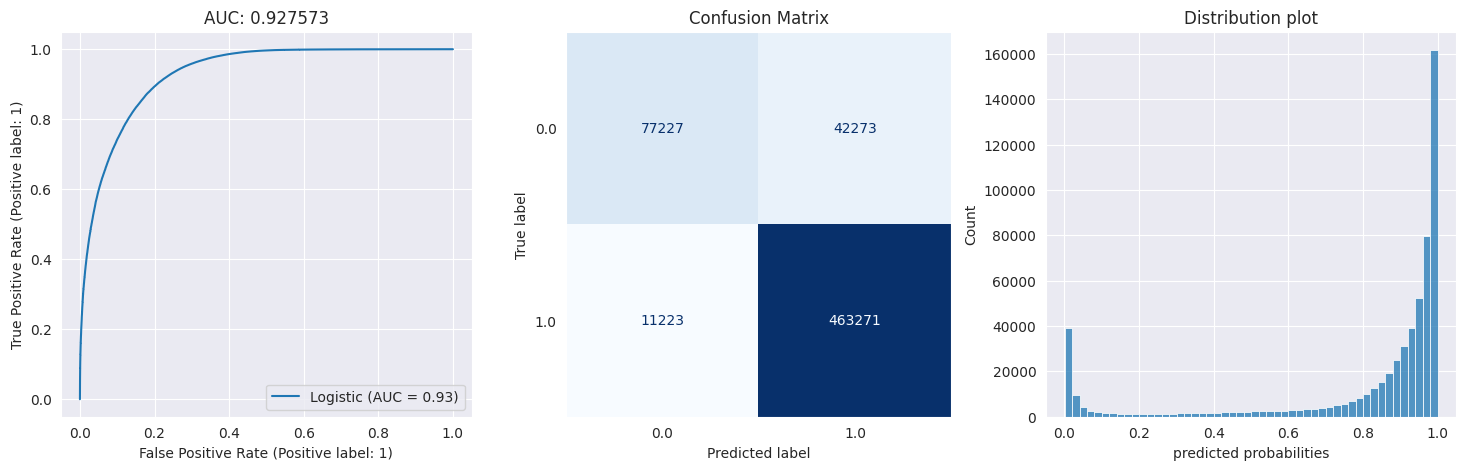

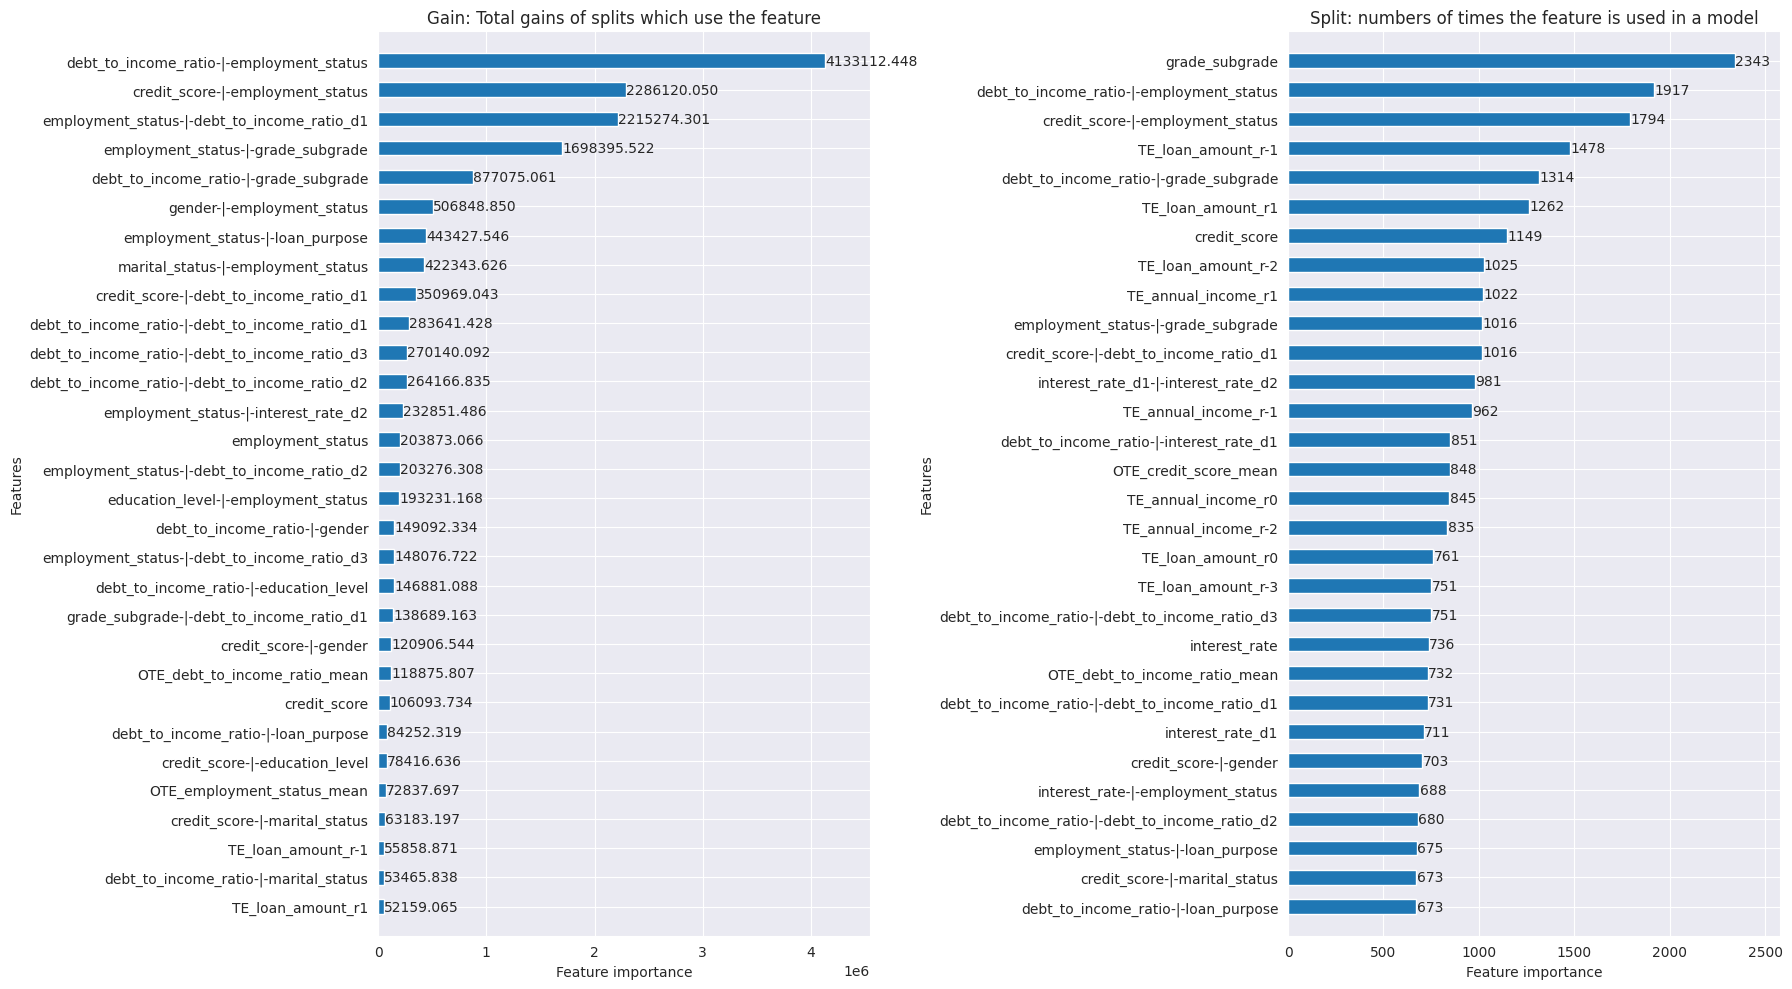

In [24]:
_, axs = plt.subplots(1, 3, figsize=(18, 5))
## -- ROC curve --
RocCurveDisplay.from_predictions(y, oof_preds, name='Logistic', ax=axs[0])
axs[0].set_title(f"AUC: {overall_AUC:.6f}")

## -- Confusion matrix (threshold = 0.5) --
ConfusionMatrixDisplay.from_predictions(y, pred_labels, cmap='Blues', colorbar=False, ax=axs[1])
axs[1].set_title(f"Confusion Matrix")
axs[1].grid(False)

## -- Distribution plot --
sns.histplot(oof_preds, bins=50, ax=axs[2])
axs[2].set_title(f"Distribution plot")
axs[2].set_xlabel(f"predicted probabilities")

## -- Plot feature importances --
_, axs = plt.subplots(1, 2, figsize=(18, 10))
lgb.plot_importance(models[0], importance_type='gain', max_num_features=30, height=0.5, ax=axs[0])
axs[0].set_title('Gain: Total gains of splits which use the feature')
lgb.plot_importance(models[0], importance_type='split', max_num_features=30, height=0.5, ax=axs[1])
axs[1].set_title('Split: numbers of times the feature is used in a model')
plt.tight_layout()
plt.show()

In [25]:
s = str(overall_AUC).split('.')[1][:6]
np.save(f"oof_LGB_{s}.npy", oof_preds)
np.save(f"pred_LGB_{s}.npy", test_preds)
print(f"✅ oof & prediction files saved!")

submit[TARGET] = test_preds
submit.to_csv(f"submit_LGB_{s}.csv", index=False)

print(f"✅ submit_LGB_{s}.csv file saved!")

✅ oof & prediction files saved!
✅ submit_LGB_927572.csv file saved!
